In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DA07/data/중급2/feature_attended_df.csv")

In [ ]:
df.shape

(6518, 23)

In [ ]:
df.isna().sum().sum()

np.int64(0)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.columns

Index(['user_uuid', 'register_weekday', 'register_month', 'register_year',
       'visit_count', 'visit_year', 'visit_month', 'visit_weekday',
       'total_stay_time', 'avg_first_enter_period', 'site_id', 'is_attend',
       'is_payment', 'area_pyeong', 'bus(250m)', 'subway(250m)',
       'bicycle(250m)', 'nearest bus', 'nearest subway', 'nearest bicycle',
       'total population (1km)', 'productive population(1km)',
       'restaurant(250m)'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_uuid                   6518 non-null   object 
 1   register_weekday            6518 non-null   int64  
 2   register_month              6518 non-null   int64  
 3   register_year               6518 non-null   int64  
 4   visit_count                 6518 non-null   int64  
 5   visit_year                  6518 non-null   int64  
 6   visit_month                 6518 non-null   int64  
 7   visit_weekday               6518 non-null   int64  
 8   total_stay_time             6518 non-null   int64  
 9   avg_first_enter_period      6518 non-null   object 
 10  site_id                     6518 non-null   int64  
 11  is_attend                   6518 non-null   int64  
 12  is_payment                  6518 non-null   int64  
 13  area_pyeong                 6518 

In [ ]:
# user_uuid는 식별자로, 모델링에서 제외
# is_payment는 타겟 변수로 제외
# is_attend는 모두 1이기에 제외
num_cols = ['visit_count', 'total_stay_time', 'area_pyeong',
    'bus(250m)', 'subway(250m)', 'bicycle(250m)',
    'nearest bus', 'nearest subway', 'nearest bicycle',
    'total population (1km)', 'productive population(1km)',
    'restaurant(250m)']
cat_cols = ['avg_first_enter_period',
    'register_weekday', 'register_month', 'register_year',
    'visit_weekday', 'visit_month', 'visit_year',
    'site_id']

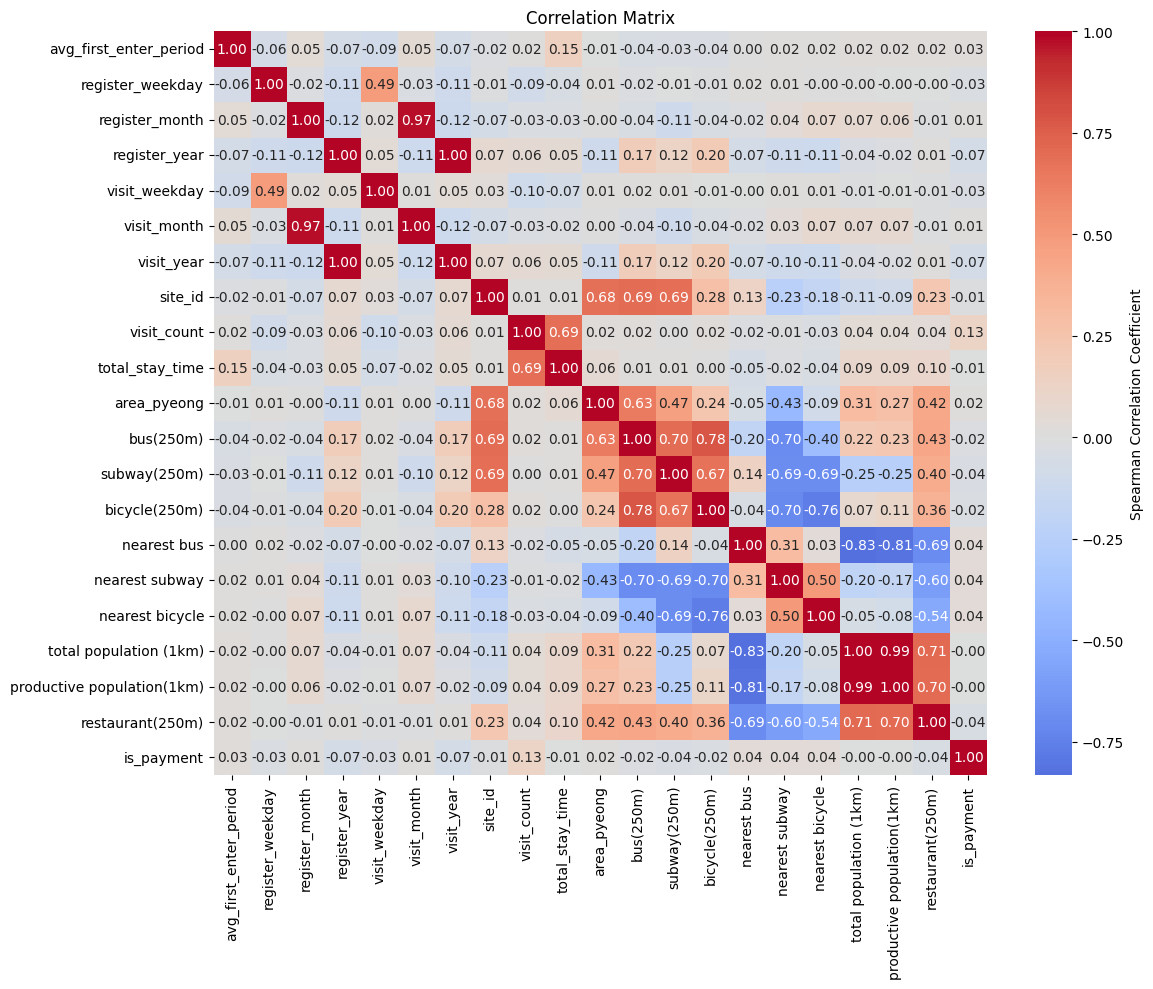

In [ ]:
# 변수간 상관관계
all_cols_corr = cat_cols + num_cols + ['is_payment']

df_encoded = pd.DataFrame()
le = LabelEncoder()

for col in all_cols_corr:
    if col in cat_cols:
        df_encoded[col] = le.fit_transform(df[col].astype(str))
    else:
        df_encoded[col] = df[col]

corr_matrix = df_encoded.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            cbar_kws={'label': 'Spearman Correlation Coefficient'})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
df_encoded.columns

Index(['avg_first_enter_period', 'register_weekday', 'register_month',
       'register_year', 'visit_weekday', 'visit_month', 'visit_year',
       'site_id', 'visit_count', 'total_stay_time', 'area_pyeong', 'bus(250m)',
       'subway(250m)', 'bicycle(250m)', 'nearest bus', 'nearest subway',
       'nearest bicycle', 'total population (1km)',
       'productive population(1km)', 'restaurant(250m)', 'is_payment'],
      dtype='object')

In [ ]:
# VIF 체크
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_encoded[ [ 'visit_count', 'total_stay_time', 'area_pyeong', 'productive population(1km)',  'nearest subway',
       'nearest bicycle', 'avg_first_enter_period', 'register_weekday', 'visit_weekday', 'visit_month', 'visit_year',]]
# X = df_encoded.drop(columns=['is_payment', 'total population (1km)', 'site_id', 'register_year', 'register_month', 'bus(250m)', 'bicycle(250m)', 'subway(250m)', 'restaurant(250m)'])


# VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 높은 순으로 정렬
vif_data.sort_values(by='VIF', ascending=False)



,feature,VIF
0,visit_count,9.601914
2,area_pyeong,6.799495
3,productive population(1km),6.041911
4,nearest subway,5.037129
1,total_stay_time,4.596821
8,visit_weekday,4.042868
9,visit_month,3.362031
7,register_weekday,3.174654
10,visit_year,2.762598
6,avg_first_enter_period,1.837764


## 모델링 with all variables

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve,
    f1_score, roc_auc_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay
)

In [ ]:
X = df[num_cols + cat_cols]
y = df["is_payment"]

In [ ]:
# 범주형 변수 인코딩
X = pd.get_dummies(X, columns=cat_cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [ ]:
# 수치형 변수 스케일링
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# 수치형 + 범주형 결합
X_train_final = pd.concat([X_train_num, X_train.drop(columns=num_cols)], axis=1)
X_test_final = pd.concat([X_test_num, X_test.drop(columns=num_cols)], axis=1)

In [ ]:
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # 예측값
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 확률 예측값 (테스트용)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # 결과 저장
    results[name] = {
        "Accuracy_train": accuracy_score(y_train, y_train_pred),
        "Accuracy_test": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC_AUC": roc_auc_score(y_test, y_test_proba)
    }

    print(f"\nModel: {name}")
    for k, v in results[name].items():
        print(f"{k}: {v:.4f}")

In [ ]:
scale_ratio = len(y[y==0]) / len(y[y==1])
scale_ratio

1.553074813944379

In [ ]:
# @title 모델 리스트 정의 (트리 기반 앙상블 모델만)
models = {
    # "Logistic Regression": LogisticRegression(),
    # "Logistic Regression Balanced": LogisticRegression(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(),
    "Decision Tree Balanced": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),
    "Random Forest Balanced": RandomForestClassifier(class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "XGBoost Balanced": XGBClassifier(scale_pos_weight=scale_ratio),
    "LightGBM": LGBMClassifier(),
    "LightGBM Balanced": LGBMClassifier(scale_pos_weight=scale_ratio),
    # "SVM": SVC(probability=True),
    # "SVM Balanced": SVC(probability=True, class_weight='balanced'),
    # "KNN": KNeighborsClassifier()
}

In [ ]:
# @title Bagging 별도 처리
bagging_models = {
    "Bagging (Decision Tree)": BaggingClassifier(estimator=models["Decision Tree"], random_state=42),
    "Bagging (Decision Tree Balanced)": BaggingClassifier(estimator=models["Decision Tree Balanced"], random_state=42)
}

In [ ]:
# @title 모델 학습 및 평가
for name, model in {**models, **bagging_models}.items():
    if name in ["Logistic Regression", "Logistic Regression Balanced", "SVM", "SVM Balanced", "KNN"]:
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)
        evaluate_model(name, model, X_train_final, y_train, X_test_final, y_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        evaluate_model(name, model, X_train, y_train, X_test, y_test)



Model: Decision Tree
Accuracy_train: 1.0000
Accuracy_test: 0.5613
Precision: 0.4415
Recall: 0.4501
F1: 0.4457
ROC_AUC: 0.5416

Model: Decision Tree Balanced
Accuracy_train: 1.0000
Accuracy_test: 0.5836
Precision: 0.4695
Recall: 0.4814
F1: 0.4754
ROC_AUC: 0.5654

Model: Random Forest
Accuracy_train: 1.0000
Accuracy_test: 0.5966
Precision: 0.4805
Recall: 0.3620
F1: 0.4129
ROC_AUC: 0.6175

Model: Random Forest Balanced
Accuracy_train: 1.0000
Accuracy_test: 0.6089
Precision: 0.5013
Recall: 0.3640
F1: 0.4218
ROC_AUC: 0.6149

Model: AdaBoost
Accuracy_train: 0.6379
Accuracy_test: 0.6373
Precision: 0.5950
Recall: 0.2329
F1: 0.3347
ROC_AUC: 0.6282

Model: Gradient Boosting
Accuracy_train: 0.6834
Accuracy_test: 0.6365
Precision: 0.5720
Recall: 0.2877
F1: 0.3828
ROC_AUC: 0.6256

Model: XGBoost
Accuracy_train: 0.9125
Accuracy_test: 0.6166
Precision: 0.5141
Recall: 0.3914
F1: 0.4444
ROC_AUC: 0.6156

Model: XGBoost Balanced
Accuracy_train: 0.9141
Accuracy_test: 0.5920
Precision: 0.4800
Recall: 0.49

In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by=["F1", "ROC_AUC"], ascending=False)
print("\n\n===== 최종 정리된 모델 성능 비교표 =====")
print(results_df[["Precision", "Recall", "F1", "ROC_AUC", "Accuracy_train", "Accuracy_test"]])



===== 최종 정리된 모델 성능 비교표 =====
                                  Precision    Recall        F1   ROC_AUC  \
LightGBM Balanced                  0.501818  0.540117  0.520264  0.634991   
XGBoost Balanced                   0.480000  0.493151  0.486486  0.609299   
Decision Tree Balanced             0.469466  0.481409  0.475362  0.565421   
Decision Tree                      0.441459  0.450098  0.445736  0.541568   
XGBoost                            0.514139  0.391389  0.444444  0.615639   
Bagging (Decision Tree)            0.525745  0.379648  0.440909  0.617132   
Bagging (Decision Tree Balanced)   0.528249  0.365949  0.432370  0.619463   
Random Forest Balanced             0.501348  0.363992  0.421769  0.614898   
LightGBM                           0.551948  0.332681  0.415140  0.630531   
Random Forest                      0.480519  0.362035  0.412946  0.617470   
Gradient Boosting                  0.571984  0.287671  0.382812  0.625601   
AdaBoost                           0.595000  

### 하이퍼 파라미터 튜닝

In [ ]:
# @title LightGBM Balanced
param_grid = {
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 7, 9],
    'num_leaves': [45, 50, 60],
    'min_child_samples': [10, 20],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.8, 1.0, 1.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_lgbm = RandomizedSearchCV(
    estimator=models["LightGBM Balanced"],
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
grid_lgbm.fit(X_train, y_train)
print("Best Params:", grid_lgbm.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2042, number of negative: 3172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 5214, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391638 -> initscore=-0.440433
[LightGBM] [Info] Start training from score -0.440433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [ ]:
lgbmbb = LGBMClassifier(**grid_lgbm.best_params_, class_weight="balanced")
lgbmbb.fit(X_train, y_train)
evaluate_model("LightGBM Classifier Balanced Best", lgbmbb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2042, number of negative: 3172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 5214, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Model: LightGBM Classifier Balanced Best
Accuracy_train: 0.7472
A

In [ ]:
# @title XGB Balanced
param_grid = {
    'learning_rate': [0.005, 0.01, 0.02],
    'max_depth': [4, 5, 6],
    'n_estimators': [100, 150, 200],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0],
    'scale_pos_weight': [scale_ratio]
}

grid_xgb = RandomizedSearchCV(
    estimator=models["XGBoost Balanced"],
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
grid_xgb.fit(X_train, y_train)
print("Best Params:", grid_xgb.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'subsample': 1.0, 'scale_pos_weight': 1.553074813944379, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [ ]:
xgbb = XGBClassifier(**grid_xgb.best_params_)
xgbb.fit(X_train, y_train)
evaluate_model("XGB Classifier Balanced Best", xgbb, X_train, y_train, X_test, y_test )


Model: XGB Classifier Balanced Best
Accuracy_train: 0.6724
Accuracy_test: 0.6058
Precision: 0.4974
Recall: 0.5636
F1: 0.5284
ROC_AUC: 0.6279


In [ ]:
# @title Decision Tree Balanced
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(models["Decision Tree Balanced"], param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Best Params:", grid_dt.best_params_)

Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
lrbb = DecisionTreeClassifier(**grid_dt.best_params_, class_weight="balanced")
lrbb.fit(X_train, y_train)
evaluate_model("Decision Tree Balanced Best", lrbb, X_train, y_train, X_test, y_test )


Model: Decision Tree Balanced Best
Accuracy_train: 0.6285
Accuracy_test: 0.5905
Precision: 0.4778
Recall: 0.4834
F1: 0.4805
ROC_AUC: 0.6060


In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by=["F1", "ROC_AUC"], ascending=False)
print("\n\n===== 최종 정리된 모델 성능 비교표 =====")
print(results_df[["Precision", "Recall", "F1", "ROC_AUC", "Accuracy_train", "Accuracy_test"]])



===== 최종 정리된 모델 성능 비교표 =====
                                   Precision    Recall        F1   ROC_AUC  \
LightGBM Classifier Balanced Best   0.505245  0.565558  0.533703  0.640141   
XGB Classifier Balanced Best        0.497409  0.563601  0.528440  0.627932   
LightGBM Balanced                   0.501818  0.540117  0.520264  0.634991   
XGBoost Balanced                    0.480000  0.493151  0.486486  0.609299   
Decision Tree Balanced Best         0.477756  0.483366  0.480545  0.605993   
Decision Tree Balanced              0.469466  0.481409  0.475362  0.565421   
Decision Tree                       0.441459  0.450098  0.445736  0.541568   
XGBoost                             0.514139  0.391389  0.444444  0.615639   
Bagging (Decision Tree)             0.525745  0.379648  0.440909  0.617132   
Bagging (Decision Tree Balanced)    0.528249  0.365949  0.432370  0.619463   
Random Forest Balanced              0.501348  0.363992  0.421769  0.614898   
LightGBM                         

- 파라미터 튜닝한 LightGBM을 최종 모델로 선정

In [ ]:
y_proba = lgbmbb.predict_proba(X_test)[:, 1]

# 2. threshold 범위 지정
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

# 3. 각 threshold에 대해 F1-score 계산
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    score = f1_score(y_test, y_pred)
    f1_scores.append(score)

# 4. 가장 높은 F1-score 지점 찾기
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

In [ ]:
best_thresh, best_f1

(np.float64(0.37), 0.579088471849866)

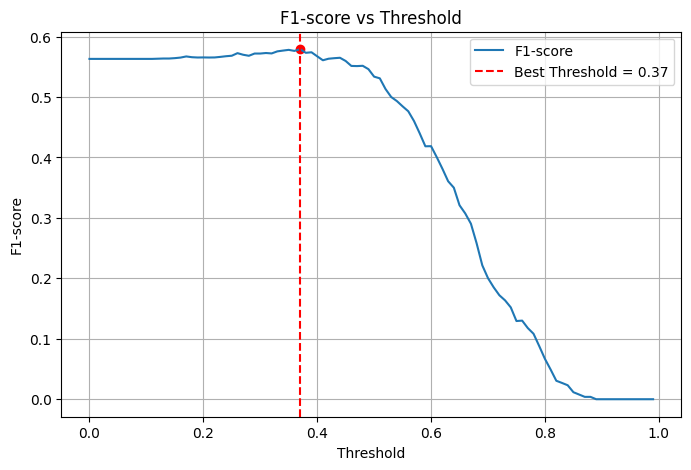

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(x=best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.scatter([best_thresh], [best_f1], color='red')
plt.title("F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# @title 최적의 threshold를 통한 결과값
y_proba = lgbmbb.predict_proba(X_test)[:, 1]
y_pred_best = (y_proba >= best_thresh).astype(int)

print(f"final threshold: {best_thresh}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best)}")
print(f"Precision: {precision_score(y_test, y_pred_best)}")
print(f"Recall: {recall_score(y_test, y_pred_best)}")
print(f"F1: {f1_score(y_test, y_pred_best)}")
print(f"ROC_AUC: {roc_auc_score(y_test, y_proba)}")

final threshold: 0.37
Accuracy: 0.5184049079754601
Precision: 0.44036697247706424
Recall: 0.8454011741682974
F1: 0.579088471849866
ROC_AUC: 0.640141354266663


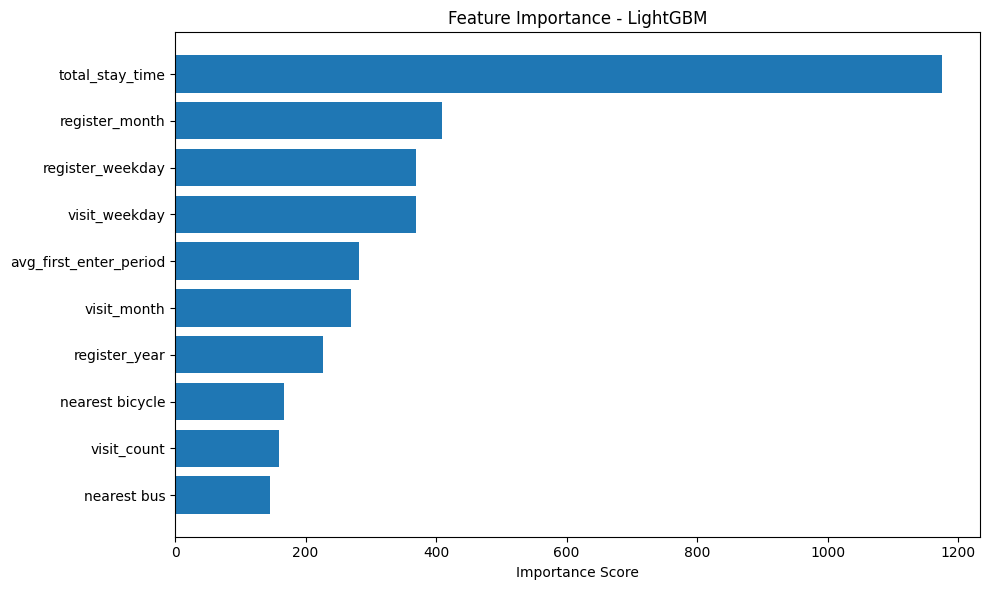

In [ ]:
best_lgbm = grid_lgbm.best_estimator_
features = X_train_final.columns
importances = best_lgbm.feature_importances_

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

group_mapping = {
    'visit_count': 'visit_count',
    'total_stay_time': 'total_stay_time',
    'area_pyeong': 'area_pyeong',
    'bus(250m)': 'bus(250m)',
    'subway(250m)': 'subway(250m)',
    'bicycle(250m)': 'bicycle(250m)',
    'nearest bus': 'nearest bus',
    'nearest subway': 'nearest subway',
    'nearest bicycle': 'nearest bicycle',
    'total population (1km)': 'total population',
    'productive population(1km)': 'productive population',
    'restaurant(250m)': 'restaurant(250m)',

    'avg_first_enter_period_afternoon': 'avg_first_enter_period',
    'avg_first_enter_period_evening': 'avg_first_enter_period',
    'avg_first_enter_period_morning': 'avg_first_enter_period',
    'avg_first_enter_period_night': 'avg_first_enter_period',
}

def map_group(feature):
    if feature in group_mapping:
        return group_mapping[feature]
    elif any(feature.startswith(prefix) for prefix in [
        'register_weekday_', 'register_month_', 'register_year_',
        'visit_weekday_', 'visit_month_', 'visit_year_',
    ]):
        return '_'.join(feature.split('_')[:2])
    else:
        return feature.split('_')[0]

importance_df['Grouped'] = importance_df['Feature'].map(map_group)

# 그룹 합산
grouped_importance = importance_df.groupby('Grouped')['Importance'].sum().sort_values(ascending=False).reset_index()

# 시각화
plt.figure(figsize=(10,6))
plt.barh(grouped_importance['Grouped'][:10][::-1], grouped_importance['Importance'][:10][::-1])
plt.xlabel('Importance Score')
plt.title('Feature Importance - LightGBM')
plt.tight_layout()
plt.show()


In [ ]:
grouped_importance

,Grouped,Importance
0,total_stay_time,1175
1,register_month,409
2,register_weekday,370
3,visit_weekday,369
4,avg_first_enter_period,282
5,visit_month,269
6,register_year,227
7,nearest bicycle,167
8,visit_count,160
9,nearest bus,146


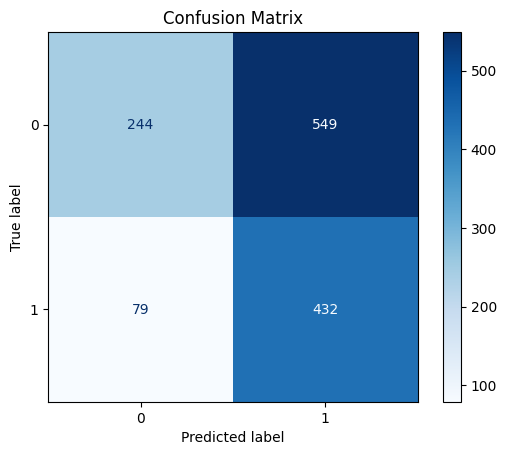

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbmbb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Modeling

## 모델링 without register, productive populations

In [ ]:
# user_uuid는 식별자로, 모델링에서 제외
# is_payment는 타겟 변수로 제외
# is_attend는 모두 1이기에 제외
# register_year/month/weekday는 visit_관련 변수와 상관관계가 높기에 제외
# productive population은 total population과 상관관계가 높기에 제외
num_cols = ['visit_count', 'total_stay_time', 'area_pyeong',
    'bus(250m)', 'subway(250m)', 'bicycle(250m)',
    'nearest bus', 'nearest subway', 'nearest bicycle',
    'total population (1km)',
    'restaurant(250m)']
cat_cols = ['avg_first_enter_period',
    'visit_weekday', 'visit_month', 'visit_year',
    'site_id']

In [ ]:
X = df[num_cols + cat_cols]
y = df["is_payment"]

In [ ]:
# 범주형 변수 인코딩
X = pd.get_dummies(X, columns=cat_cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [ ]:
# 수치형 변수 스케일링
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# 수치형 + 범주형 결합
X_train_final = pd.concat([X_train_num, X_train.drop(columns=num_cols)], axis=1)
X_test_final = pd.concat([X_test_num, X_test.drop(columns=num_cols)], axis=1)

In [ ]:
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # 예측값
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 확률 예측값 (테스트용)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # 결과 저장
    results[name] = {
        "Accuracy_train": accuracy_score(y_train, y_train_pred),
        "Accuracy_test": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC_AUC": roc_auc_score(y_test, y_test_proba)
    }

    print(f"\nModel: {name}")
    for k, v in results[name].items():
        print(f"{k}: {v:.4f}")

In [ ]:
scale_ratio = len(y[y==0]) / len(y[y==1])
scale_ratio

1.553074813944379

In [ ]:
# @title 모델 리스트 정의 (트리 기반 앙상블 모델만)
models = {
    # "Logistic Regression": LogisticRegression(),
    # "Logistic Regression Balanced": LogisticRegression(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(),
    "Decision Tree Balanced": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),
    "Random Forest Balanced": RandomForestClassifier(class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "XGBoost Balanced": XGBClassifier(scale_pos_weight=scale_ratio),
    "LightGBM": LGBMClassifier(),
    "LightGBM Balanced": LGBMClassifier(scale_pos_weight=scale_ratio),
    # "SVM": SVC(probability=True),
    # "SVM Balanced": SVC(probability=True, class_weight='balanced'),
    # "KNN": KNeighborsClassifier()
}

In [ ]:
# @title Bagging 별도 처리
bagging_models = {
    "Bagging (Decision Tree)": BaggingClassifier(estimator=models["Decision Tree"], random_state=42),
    "Bagging (Decision Tree Balanced)": BaggingClassifier(estimator=models["Decision Tree Balanced"], random_state=42)
}

In [ ]:
# @title 모델 학습 및 평가
for name, model in {**models, **bagging_models}.items():
    if name in ["Logistic Regression", "Logistic Regression Balanced", "SVM", "SVM Balanced", "KNN"]:
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)
        evaluate_model(name, model, X_train_final, y_train, X_test_final, y_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        evaluate_model(name, model, X_train, y_train, X_test, y_test)



Model: Decision Tree
Accuracy_train: 1.0000
Accuracy_test: 0.5897
Precision: 0.4777
Recall: 0.5029
F1: 0.4900
ROC_AUC: 0.5743

Model: Decision Tree Balanced
Accuracy_train: 1.0000
Accuracy_test: 0.5905
Precision: 0.4783
Recall: 0.4951
F1: 0.4865
ROC_AUC: 0.5735

Model: Random Forest
Accuracy_train: 1.0000
Accuracy_test: 0.5959
Precision: 0.4804
Recall: 0.3836
F1: 0.4266
ROC_AUC: 0.6027

Model: Random Forest Balanced
Accuracy_train: 1.0000
Accuracy_test: 0.5982
Precision: 0.4842
Recall: 0.3894
F1: 0.4317
ROC_AUC: 0.6011

Model: AdaBoost
Accuracy_train: 0.6356
Accuracy_test: 0.6388
Precision: 0.6053
Recall: 0.2250
F1: 0.3281
ROC_AUC: 0.6250

Model: Gradient Boosting
Accuracy_train: 0.6780
Accuracy_test: 0.6281
Precision: 0.5504
Recall: 0.2779
F1: 0.3693
ROC_AUC: 0.6226

Model: XGBoost
Accuracy_train: 0.8872
Accuracy_test: 0.6158
Precision: 0.5126
Recall: 0.3992
F1: 0.4488
ROC_AUC: 0.6087

Model: XGBoost Balanced
Accuracy_train: 0.9081
Accuracy_test: 0.5989
Precision: 0.4885
Recall: 0.49

In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by=["F1", "ROC_AUC"], ascending=False)
print("\n\n===== 최종 정리된 모델 성능 비교표 =====")
print(results_df[["Precision", "Recall", "F1", "ROC_AUC", "Accuracy_train", "Accuracy_test"]])



===== 최종 정리된 모델 성능 비교표 =====
                                  Precision    Recall        F1   ROC_AUC  \
LightGBM Balanced                  0.493827  0.547945  0.519481  0.627244   
XGBoost Balanced                   0.488506  0.499022  0.493708  0.601791   
Decision Tree                      0.477695  0.502935  0.489990  0.574292   
Decision Tree Balanced             0.478261  0.495108  0.486538  0.573531   
XGBoost                            0.512563  0.399217  0.448845  0.608711   
Random Forest Balanced             0.484185  0.389432  0.431670  0.601094   
Bagging (Decision Tree)            0.513736  0.365949  0.427429  0.604240   
Random Forest                      0.480392  0.383562  0.426551  0.602683   
Bagging (Decision Tree Balanced)   0.489529  0.365949  0.418813  0.592481   
LightGBM                           0.535826  0.336595  0.413462  0.629092   
Gradient Boosting                  0.550388  0.277886  0.369311  0.622597   
AdaBoost                           0.605263  

In [ ]:
# @title LightGBM Balanced
param_grid = {
    'learning_rate': [0.05],  # 고정
    'max_depth': [7, 9, -1],
    'num_leaves': [31, 40, 50],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1.0]
}


grid_lgbm = RandomizedSearchCV(
    estimator=models["LightGBM Balanced"],
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
grid_lgbm.fit(X_train, y_train)
print("Best Params:", grid_lgbm.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2042, number of negative: 3172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 5214, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391638 -> initscore=-0.440433
[LightGBM] [Info] Start training from score -0.440433
Best Params: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0, 'num_leaves': 31, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [ ]:
lgbmbb = LGBMClassifier(**grid_lgbm.best_params_,  class_weight="balanced")
lgbmbb.fit(X_train, y_train)
evaluate_model("LightGBM Classifier Balanced Best", lgbmbb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2042, number of negative: 3172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 5214, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Model: LightGBM Classifier Balanced Best
Accuracy_train: 0.7248
Accuracy_test: 0.6104
Precision: 0.5026
Recall: 0.5656
F1: 0.5322
ROC_AUC: 0.6285


In [ ]:
# @title XGB Balanced
param_grid = {
    'learning_rate': [0.005, 0.01, 0.02],
    'max_depth': [4, 5, 6],
    'n_estimators': [100, 150, 200],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0],
    'scale_pos_weight': [scale_ratio]
}

grid_xgb = RandomizedSearchCV(
    estimator=models["XGBoost Balanced"],
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
grid_xgb.fit(X_train, y_train)
print("Best Params:", grid_xgb.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'subsample': 1.0, 'scale_pos_weight': 1.553074813944379, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [ ]:
xgbb = XGBClassifier(**grid_xgb.best_params_)
xgbb.fit(X_train, y_train)
evaluate_model("XGB Classifier Balanced Best", xgbb, X_train, y_train, X_test, y_test )


Model: XGB Classifier Balanced Best
Accuracy_train: 0.6717
Accuracy_test: 0.6066
Precision: 0.4983
Recall: 0.5753
F1: 0.5341
ROC_AUC: 0.6265


In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by=["F1", "ROC_AUC"], ascending=False)
print("\n\n===== 최종 정리된 모델 성능 비교표 =====")
print(results_df[["Precision", "Recall", "F1", "ROC_AUC", "Accuracy_train", "Accuracy_test"]])



===== 최종 정리된 모델 성능 비교표 =====
                                   Precision    Recall        F1   ROC_AUC  \
XGB Classifier Balanced Best        0.498305  0.575342  0.534060  0.626487   
LightGBM Classifier Balanced Best   0.502609  0.565558  0.532228  0.628538   
LightGBM Balanced                   0.493827  0.547945  0.519481  0.627244   
XGBoost Balanced                    0.488506  0.499022  0.493708  0.601791   
Decision Tree                       0.477695  0.502935  0.489990  0.574292   
Decision Tree Balanced              0.478261  0.495108  0.486538  0.573531   
XGBoost                             0.512563  0.399217  0.448845  0.608711   
Random Forest Balanced              0.484185  0.389432  0.431670  0.601094   
Bagging (Decision Tree)             0.513736  0.365949  0.427429  0.604240   
Random Forest                       0.480392  0.383562  0.426551  0.602683   
Bagging (Decision Tree Balanced)    0.489529  0.365949  0.418813  0.592481   
LightGBM                         

- 파라미터 튜닝한 LightGBM을 최종 모델로 선정

In [ ]:
y_proba = lgbmbb.predict_proba(X_test)[:, 1]

# 2. threshold 범위 지정
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

# 3. 각 threshold에 대해 F1-score 계산
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    score = f1_score(y_test, y_pred)
    f1_scores.append(score)

# 4. 가장 높은 F1-score 지점 찾기
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

In [ ]:
best_thresh, best_f1

(np.float64(0.39), 0.5733695652173914)

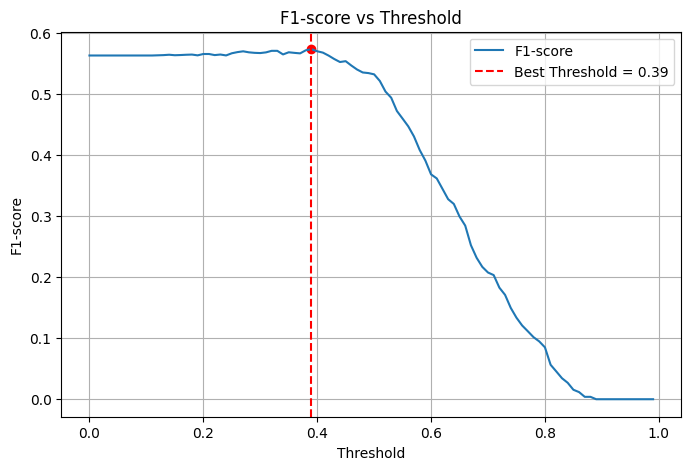

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(x=best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.scatter([best_thresh], [best_f1], color='red')
plt.title("F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# @title 최적의 threshold를 통한 결과값
y_proba = lgbmbb.predict_proba(X_test)[:, 1]
y_pred_best = (y_proba >= best_thresh).astype(int)

print(f"final threshold: {best_thresh}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best)}")
print(f"Precision: {precision_score(y_test, y_pred_best)}")
print(f"Recall: {recall_score(y_test, y_pred_best)}")
print(f"F1: {f1_score(y_test, y_pred_best)}")
print(f"ROC_AUC: {roc_auc_score(y_test, y_proba)}")

final threshold: 0.39
Accuracy: 0.5184049079754601
Precision: 0.43912591050988553
Recall: 0.8258317025440313
F1: 0.5733695652173914
ROC_AUC: 0.6285378668042041


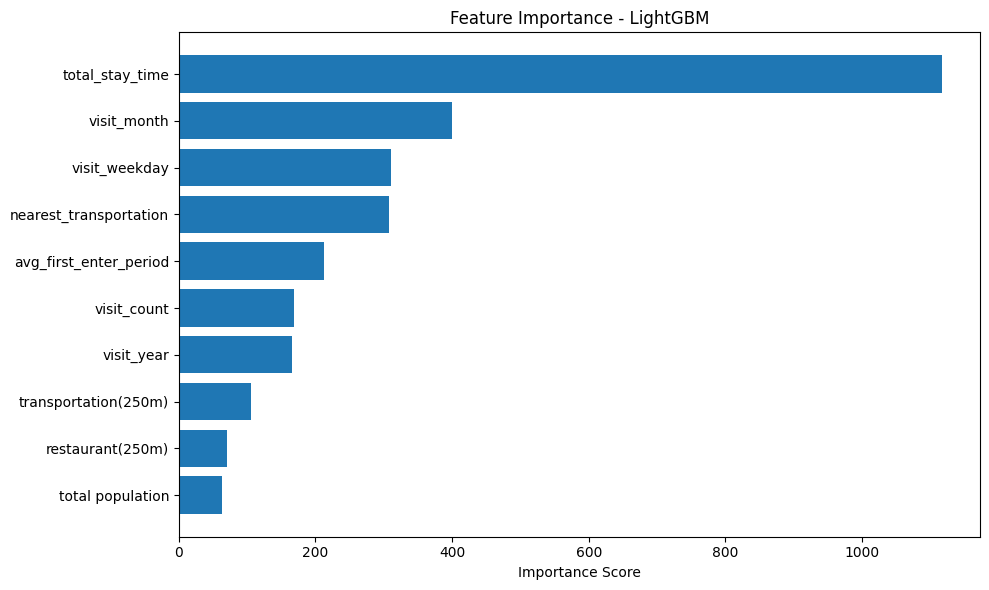

In [ ]:
best_lgbm = grid_lgbm.best_estimator_
features = X_train_final.columns
importances = best_lgbm.feature_importances_

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

group_mapping = {
    'visit_count': 'visit_count',
    'total_stay_time': 'total_stay_time',
    'area_pyeong': 'area_pyeong',
    'bus(250m)': 'transportation(250m)',
    'subway(250m)': 'transportation(250m)',
    'bicycle(250m)': 'transportation(250m)',
    'nearest bus': 'nearest_transportation',
    'nearest subway': 'nearest_transportation',
    'nearest bicycle': 'nearest_transportation',
    'total population (1km)': 'total population',
    'productive population(1km)': 'productive population',
    'restaurant(250m)': 'restaurant(250m)',

    'avg_first_enter_period_afternoon': 'avg_first_enter_period',
    'avg_first_enter_period_evening': 'avg_first_enter_period',
    'avg_first_enter_period_morning': 'avg_first_enter_period',
    'avg_first_enter_period_night': 'avg_first_enter_period',
}

def map_group(feature):
    if feature in group_mapping:
        return group_mapping[feature]
    elif any(feature.startswith(prefix) for prefix in [
        'register_weekday_', 'register_month_', 'register_year_',
        'visit_weekday_', 'visit_month_', 'visit_year_',
    ]):
        return '_'.join(feature.split('_')[:2])
    else:
        return feature.split('_')[0]

importance_df['Grouped'] = importance_df['Feature'].map(map_group)

# 그룹 합산
grouped_importance = importance_df.groupby('Grouped')['Importance'].sum().sort_values(ascending=False).reset_index()

# 시각화
plt.figure(figsize=(10,6))
plt.barh(grouped_importance['Grouped'][:10][::-1], grouped_importance['Importance'][:10][::-1])
plt.xlabel('Importance Score')
plt.title('Feature Importance - LightGBM')
plt.tight_layout()
plt.show()


In [ ]:
grouped_importance

,Grouped,Importance
0,total_stay_time,1117
1,visit_month,400
2,visit_weekday,311
3,nearest_transportation,307
4,avg_first_enter_period,213
5,visit_count,168
6,visit_year,165
7,transportation(250m),105
8,restaurant(250m),71
9,total population,63


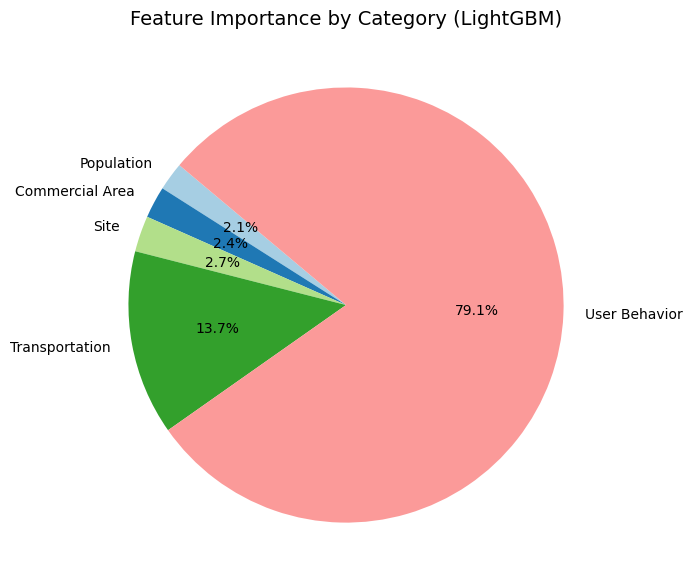

In [ ]:
category_map = {
    'total_stay_time': 'User Behavior',
    'visit_month': 'User Behavior',
    'visit_weekday': 'User Behavior',
    'avg_first_enter_period': 'User Behavior',
    'visit_count': 'User Behavior',
    'visit_year': 'User Behavior',
    'nearest_transportation': 'Transportation',
    'transportation(250m)': 'Transportation',
    'restaurant(250m)': 'Commercial Area',
    'total population': 'Population',
    'area_pyeong': 'Site',
    'site': 'Site'
}

importance_df['Category'] = importance_df['Grouped'].map(category_map)

category_summary = importance_df.groupby('Category')['Importance'].sum().reset_index()
category_summary['Percentage'] = category_summary['Importance'] / category_summary['Importance'].sum() * 100
category_summary = category_summary.sort_values(by='Percentage', ascending=True)

plt.figure(figsize=(7, 7))
plt.pie(
    category_summary['Percentage'],
    labels=category_summary['Category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title('Feature Importance by Category (LightGBM)', fontsize=14)
plt.tight_layout()
plt.show()

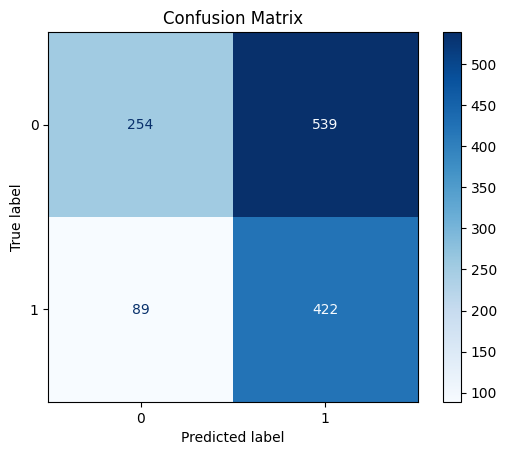

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbmbb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()